## Goal
To develop further capability with numerical methods for integration.

We will also have a brief introduction to the idea of numerical
approximation of derivatives, as preparation for thinking about
ordinary and partial differential equations.

## Readings
Let us list all the sections we are covering in Newman Chapter 5 **Integrals and derivatives**, including those we read last week:

    5.1 Fundamental methods for evaluating integrals

    5.2 Errors on integrals

    5.3 Choosing the number of steps

    5.4 Romberg integration*

    5.5 Higher-order integration methods

    5.7 Choosing an integration method

    5.8 Integrals over infinite ranges*

    5.10 Derivatives* -- Just read subsections 5.10.1-5.10.3 for the basics.

\* New reading this week.


In [1]:
#For colored cells, currently blue cells, black text 
#https://stackoverflow.com/questions/18024769/adding-custom-styled-paragraphs-in-markdown-cells
from IPython.core.display import HTML
def css_styling():
    styles = open("style.css", "r").read()
    return HTML(styles)
css_styling()

<div class=answer>
*This should be a blue cell with black font if you set the filepath correctly*</font>
<div/>

## Overview

There are two aspects to this week's investigations:

1.  The first is more technically oriented - we will reorient our thinking towards calculating results to a  given *tolerance*, rather than with a fixed number of steps.  We will then explore the idea of extrapolating to a more accurate answer - Romberg integration is an example of the more general approach of Richardson extrapolation, which is also applied in other contexts (in particular, solution of differential equations).

2. The second aspect is oriented towards developing savvy in the use of numerical integration.  We will develop a feel for some of the less well-behaved types of integrals which one encounters in practice, and see ways of handling integrals over infinite ranges.

This week you may use your own integration technique, or ```integrate.py``` to do this.  See some directions below the answer box for importing ```integrate.py```.  To use it, look at your work from last week, or call ```help(integrate)```.  To import the module, either you need a local copy of ```integrate.py``` in which case you can run:  

In [49]:
import integrate
import math

# benchmark function - as last week
def f_decay(x):
    return math.exp(-x)
int_decay = 1 - 1/math.e

# sample quick checks
print(integrate.integrate(f_decay,(0,1),100)[0])           #trapezoid, 100 steps
print(integrate.integrate(f_decay,(0,1),1000)[0])          #trapezoid, 1000 steps
print(integrate.integrate(f_decay,(0,1),100,order=2)[0])   #simpsons, 100 steps

0.6321258264911017
0.6321206115052712
0.6321205588636751


Or alternatively you can use the ```sys``` module (short for system) to update the filepaths that python will look for modules in.  The code for that is:  

In [3]:
#import sys
#sys.path.append("/c/Users/workshop/Documents/GitHub/Labs/Lab4")
#import integrate 


**FYI: if you modify your module, you will need to restart the kernel to use the modified codes.  There are some alternative methods, but nothing elegant
[source](https://support.enthought.com/hc/en-us/articles/204469240-Jupyter-IPython-After-editing-a-module-changes-are-not-effective-without-kernel-restart).**

## Exercise 1: 

In Section 5.2.1, Newman describes the practical method for estimating the error in a trapezoidal rule or Simpson's rule calculation.  Try these error estimates out for the trapezoidal rule on our benchmark integral, with $20$ steps
and $200$ steps.  __How close are the estimates to the actual errors?__  What about the sign (this will matter when we get to Romberg integration)? Repeat for Simpson's rule.

In [55]:
import integrate 
import math
t = 1
actual = 1-math.exp(-1)
N = [20,200]
res01 = []
res02 = []
err01 = []
err02 = []

def func(x):
    y = math.exp(-(x))
    return y

# Integrate for each N in list above using trapezoid rule and add the error to the list err01
for i in range(len(N)):
    I = integrate.integrate(func,(0,t),N[i],order = 1,float_type= float)[0]
    Error = (t/N[i])**2*(-math.exp(0)+math.exp(-t))/12
    err01.append(Error)
    residual = (actual - I)
    res01.append(residual)
    
    
# Integrate for each N in list above using Simpsons rule and add the error to the list err02 
for j in range(len(N)):
    I = integrate.integrate(func,(0,t),N[j],order = 2,float_type= float)[0]
    Error = (t/N[j])**4*(-math.exp(0)+math.exp(-t))/90
    err02.append(Error)
    residual = (actual - I)
    res02.append(residual)
   
    
print("The errors for N = [20,200] using the Trapezoidal rule are ",err01)
print("The errors for N = [20,200] using the Simpsons's rule are ",err02)
print("The residuals for N = [20,200] using the Trapezoidal rule are ",res01)
print("The residuals for N = [20,200] using the Simpsons's rule are ",res02)

The errors for N = [20,200] using the Trapezoidal rule are  [-0.00013169178308928287, -1.3169178308928286e-06]
The errors for N = [20,200] using the Simpsons's rule are  [-4.389726102976095e-08, -4.389726102976095e-12]
The residuals for N = [20,200] using the Trapezoidal rule are  [-0.00013168629625837092, -1.316917282445651e-06]
The residuals for N = [20,200] using the Simpsons's rule are  [-2.1942099914795676e-08, -2.1946888750790094e-12]


<div class=answer>
<div/>
Above is the difference for the four cases and in each case the numerically solved is larger, as shown by the negative sign.

## Exercise 2
### Trapezoidal rule with tolerance goal (Newman's Adaptive Method)

In practice, integration with a fixed  number of *steps* is not useful for automated use.  If your code must calculate millions of integrals (or even just hundreds of integrals), and you need a certain accuracy, it is simply impractical for you to intervene and hand-pick the number of steps for each integral.  You could just choose a "really big'' number of steps for all integrals, even when they are not needed, but this will make your code impractically slow (perhaps factors of hundreds slower than it needs to be).

Following the approach outlined in Newman Section 5.3, let us write a function which uses the trapezoidal rule to calculate with $1$, $2$, $4$, $8$, $\ldots$ steps (*i.e.*, $~2^i$ steps), until the error estimate falls below a specified tolerance.  

As Newman points out, we do not need to calculate all the points from scratch in each successive iteration.  Your
function should follow's Newman's approach, *i.e.*, "reusing'' the value of the previous integral to avoid evaluating the integrand $f$ at the same point more than once.

In fact, let us see how how much of an improvement this gives. Suppose we ultimately need, say, $2^{5}$ steps.  How many times would we have to evaluate $f$ if we evaluated the integral from scratch with each iteration ($1$, $2$, $4$, $8$, $\ldots$ steps)?  How many times would we have to evaluate $f$ if we reused the prior integrals, instead?

<div class=answer>
<div/>
If you start from scratch every time it will take 63 times to evaluate the integral, but if we reused each integral we would only need to run it 6 times.

Also, it will help if your function can produce verbose output, showing the integral and error estimate at each stage, and the residual relative to a known true value (you can peek at ```romberg.py``` for ideas on how to do this).

You can name your function ```integrate_adaptive```, and either embed it in this notebook in a code cell (as usual) or add it to the ```integrate.py``` which I gave you last week.   

In [5]:
def integrate_adaptive(f,interval,tolerance,
            verbose=False,min_order=0,max_order=None,reference=None):
    
    """ Evaluate integral by Trapezoidal Rule with Tolerance.

    f: function to integrate
    interval: tuple integration region (a,b)
    tolerance: desired absolute error
    verbose (optional):  controls diagnostic output
    min_order (optional): lowest order to carry to, regardless of tolerance
    max_order (optional): limit on order of calculation, giving failure (or None)
    reference (optional): reference value for comparison output (or None)
    """
    
     # set up integral interval
    (a,b) = interval  # endpoints

    # give initial diagnostic output
    if (verbose):
        print("integrating on range {0}".format(interval))
        if (reference != None):
            print("  reference value {:+.5e}".format(reference))
        print()
        
    # (1) Set up base case -- i=0, i.e., single-step trapezoidal rule
    # (2) Step size where exponent for number of steps can be changed as desired
    # (3) Basic trapezoidal estimate
    i = 0                         
    h = (b-a)/(2**i)               
    I0 = (1/2)*(b-a)*(f(a)+f(b))
    
    # make up error estimate to get past while condition
    eik = 2 * tolerance                                
    
    # Run a while loop that loops if the i is less than the minimum order input by the user
    # or until the the absolute value of the error is less than or equal to the tolerance
    # (1) Advance parameters to next step size 
    # (2) set the new first part of the integral equation equal to 0.5 the integral of the previous loop
    #     then reset the temporary integral to 0 to be used again
    # (3) Run a for loop that makes k go from 0 to 2 to the i power iterating odd values that calls the 
    #     function and creates a sum that is held in I_temp
    # (4) Add the sum of the heights multiplied by the width  to the past integral
    # (5) Calculate the  error to be tested
    # (6) Set the new integral to be the i-1 integral for the past loop
    while ((i < min_order) or (abs(eik) > tolerance)): 
                
        i += 1
        h /= 2
        
        I = 0.5*I0
        I_temp = 0
        
        for k in range(1,(2**i),2):
            I_temp += f(a + k*h)
            
        I += I_temp*h
        
        eik = (I - I0)/3
        
        I0 = I
        
        
        if (verbose):
            print("Error = ",eik)
            print("I = ",I0)
            print("N = ",2**i)
            print("Iteration = ",i)
            print()
       

    return I0
        
            
    

Test your new function out on the same benchmark integral
$$
\int_0^1 e^{-x}\,dx
$$
as last week, and see how many iterations $i$ (and thus steps $2^i$) are
required to achieve a tolerance of $10^{-10}$.

In [6]:
integrate_adaptive(func,(0,1),1e-10,verbose=True,reference = actual)


integrating on range (0, 1)
  reference value +6.32121e-01

Error =  -0.012901510145514624
I =  0.6452351901491773
N =  2
Iteration =  1

Error =  -0.0032752537071612706
I =  0.6354094290276935
N =  4
Iteration =  2

Error =  -0.0008220036057378088
I =  0.6329434182104801
N =  8
Iteration =  3

Error =  -0.00020570145532683437
I =  0.6323263138444996
N =  16
Iteration =  4

Error =  -5.143791680902362e-05
I =  0.6321720000940725
N =  32
Iteration =  5

Error =  -1.2860264050636635e-05
I =  0.6321334193019206
N =  64
Iteration =  6

Error =  -3.215115070139459e-06
I =  0.6321237739567102
N =  128
Iteration =  7

Error =  -8.037818336840511e-07
I =  0.6321213626112091
N =  256
Iteration =  8

Error =  -2.0094564993448452e-07
I =  0.6321207597742593
N =  512
Iteration =  9

Error =  -5.023642457580024e-08
I =  0.6321206090649856
N =  1024
Iteration =  10

Error =  -1.2559106828587593e-08
I =  0.6321205713876651
N =  2048
Iteration =  11

Error =  -3.1397771419842493e-09
I =  0.63212056196

0.632120558877616

In [7]:
print(actual)

0.6321205588285577


<div class=answer>
<div/>
It takes 15 iterations to get to an accuracy of 1e-10.

## Exercise 3
### Romberg integration

In the interest of time, I have gone ahead and provided you with code for Romberg integration in ```romberg.py```.  It is basically just a straightforward extension of what you just coded for the trapezoidal rule.  (That is, as with most code, it is straightforward in *retrospect*, once it is written...)

First, try the function ```romberg.romberg``` on our benchmark integral.  Enable the verbose output (```verbose=True```), and provide the function with the true value (```reference=...```) so it can print the residual.  Let us try for a tolerance of $10^{-10}$ again.

In [8]:
import romberg

I = romberg.romberg(func,(0,1),1e-10,verbose=True,reference = actual)

integrating on range (0, 1)
  reference value +6.32121e-01

R(0,0) +6.839397205857212e-01 ... residual -5.1819e-02

R(1,0) +6.452351901491773e-01 epsilon(1,0) -1.2902e-02 ... residual -1.3115e-02
R(1,1) +6.323336800036626e-01 ... residual -2.1312e-04

R(2,0) +6.354094290276936e-01 epsilon(2,0) -3.2753e-03 ... residual -3.2889e-03
R(2,1) +6.321341753205323e-01 epsilon(2,1) -1.3300e-05 ... residual -1.3616e-05
R(2,2) +6.321208750083236e-01 ... residual -3.1618e-07

R(3,0) +6.329434182104802e-01 epsilon(3,0) -8.2200e-04 ... residual -8.2286e-04
R(3,1) +6.321214146047424e-01 epsilon(3,1) -8.5071e-07 ... residual -8.5578e-07
R(3,2) +6.321205638903564e-01 epsilon(3,2) -4.9384e-09 ... residual -5.0618e-09
R(3,3) +6.321205589519759e-01 ... residual -1.2342e-10

R(4,0) +6.323263138444998e-01 epsilon(4,0) -2.0570e-04 ... residual -2.0576e-04
R(4,1) +6.321206123891729e-01 epsilon(4,1) -5.3481e-08 ... residual -5.3561e-08
R(4,2) +6.321205589081349e-01 epsilon(4,2) -7.9083e-11 ... residual -7.9577e

How does the number of steps (and thus the number of points at which the integrand must be evaluated) compare to the number you needed before, with the trapezoidal rule?

<div class=answer>
<div/>
It also took 5 iterations to get the value

Here is an interesting observation, which I think might make Romberg extrapolation fit in better with what we have already seen.  We now seem to have two ways of going to higher order - the good old-fashioned way of using higher-order polynomials to go through the points (Newton-Cotes) or this new clever Romberg extrapolation way.
You might have noticed that:
1. the trapezoidal rule had an error of order $O(h^2)$, 

2. Simpson's rule  had an error of order $O(h^4)$, and now 

3. the first Romberg extrapolated value $R_{i,1}$ also has an error of order $O(h^4)$

    **Caution:** I am following the $0$-based convention that $R_{i,0}$ is the trapezoidal rule value, $R_{i,1}$ is the first extrapolation, *etc.*  Note that Newman uses $1$-based numbering, starting with $R_{i,1}$ for the trapezoidal rule, *etc.*, instead.

Might the first Romberg extrapolated value actually *be* Simpson'a rule???  Or does it just have an error which happens to be of the same order?  

More concretely...  Go ahead and do Simpson's rule calculations with $2^i$ steps, and compare with the first extrapolated values in the Romberg method.  Are they the same or different?  

In [9]:
t = 1
actual = 1-math.exp(-1)
N = [2,4,8,16]
err01 = []
I1 = []

def func(x):
    y = math.exp(-(x))
    return y

# Integrate for each N in list above using trapezoid rule and add the error to the list err01
for i in range(len(N)):
    I2 = integrate.integrate(func,(0,t),N[i],order = 2,float_type= float)[0]
    Error = (actual - I2)
    err01.append(Error)
    I1.append(I2)
    
print(I1)
print()
I = romberg.romberg(func,(0,1),1e-10,verbose=True,reference = actual)

[0.6323336800036626, 0.6321341753205323, 0.6321214146047422, 0.6321206123891728]

integrating on range (0, 1)
  reference value +6.32121e-01

R(0,0) +6.839397205857212e-01 ... residual -5.1819e-02

R(1,0) +6.452351901491773e-01 epsilon(1,0) -1.2902e-02 ... residual -1.3115e-02
R(1,1) +6.323336800036626e-01 ... residual -2.1312e-04

R(2,0) +6.354094290276936e-01 epsilon(2,0) -3.2753e-03 ... residual -3.2889e-03
R(2,1) +6.321341753205323e-01 epsilon(2,1) -1.3300e-05 ... residual -1.3616e-05
R(2,2) +6.321208750083236e-01 ... residual -3.1618e-07

R(3,0) +6.329434182104802e-01 epsilon(3,0) -8.2200e-04 ... residual -8.2286e-04
R(3,1) +6.321214146047424e-01 epsilon(3,1) -8.5071e-07 ... residual -8.5578e-07
R(3,2) +6.321205638903564e-01 epsilon(3,2) -4.9384e-09 ... residual -5.0618e-09
R(3,3) +6.321205589519759e-01 ... residual -1.2342e-10

R(4,0) +6.323263138444998e-01 epsilon(4,0) -2.0570e-04 ... residual -2.0576e-04
R(4,1) +6.321206123891729e-01 epsilon(4,1) -5.3481e-08 ... residual -5.356

<div class=answer>
<div/>
They appear to be the same


Explain your result in terms of the
formulas for Simpson's rule, the trapezoidal rule, and Romberg
extrapolation.

<div class=answer>
<div/>
Answer here

## Exercise 4
### Life gets messy

** Note:** You may find your output in this section to be too much information.  You do not need to print out the entirety of the verbose output for all these
calculations.  

Now that we are equipped with all these ultrapowerful integration
algorithms, we should be ready to face any problem which is thrown at
us, right???  So calculating the area of a circle should be a piece of
cake, right?

*Ha! Since when has ```pi``` been cake?*

Plot the graph of the function $f(x)=\sqrt{1-x^2}$ on $[-1,1]$.

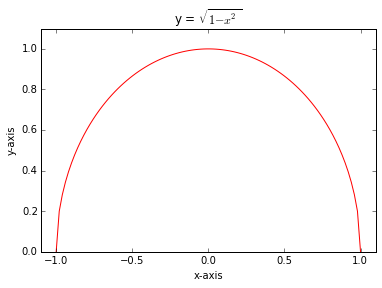

In [10]:
# We m
import math
import numpy as np 
from matplotlib.pylab import plt
% matplotlib inline
# This inputs a list of 100 numbers equally spaced from 0 to 10
x = np.linspace(-1,1,100)

# Now we are using the functions from pylab to make a list for y and y1 based on the list for x
y = np.sqrt(1-x**2)


# This plots x vs y with yellow circle and then x vs y1 with green squares
plt.plot(x,y,"r-")

# Makes the graphs y-limits go from -1.1 to 1.1 
plt.ylim(-0,1.1)
plt.xlim(-1.1,1.1)

#Finally the code below adds x and y axis labels and then displays the graph
plt.title("y = $\sqrt{1-x^2}$")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.show()

What is the analytically known value of the integral
$$
\int_{-1}^{1}\sqrt{1-x^2}\,dx?
$$
**Note:** You may quote results from elementary school without further proof.

<div class=answer>
<div/>
The area under the curve for a half circle is $(1/2)\pi r^2$ where the r is one in this case so the radias is $\pi /2$

To reach a tolerence of $10^{-10}$ with the trapezoidal rule, how many
iterations (and thus steps) are required?  Do you find that the
residual of your 
calculated result, relative to the known true value, is consistent with the
tolerance you asked for?  How about with Romberg extrapolation?

In [11]:
actual = math.pi/2

def semi_circle(x):
    return math.sqrt(1 - x**2)

integrate_adaptive(semi_circle,(-1,1),1e-10,verbose=True,reference = actual)

print(actual)

integrating on range (-1, 1)
  reference value +1.57080e+00

Error =  0.3333333333333333
I =  1.0
N =  2
Iteration =  1

Error =  0.1220084679281462
I =  1.3660254037844386
N =  4
Iteration =  2

Error =  0.043943043422260596
I =  1.4978545340512204
N =  8
Iteration =  3

Error =  0.015685012709122148
I =  1.5449095721785868
N =  16
Iteration =  4

Error =  0.005572315578427893
I =  1.5616265189138705
N =  32
Iteration =  5

Error =  0.0019748975082317286
I =  1.5675512114385657
N =  64
Iteration =  6

Error =  0.000699081650425537
I =  1.5696484563898423
N =  128
Iteration =  7

Error =  0.0002473132694883103
I =  1.5703903961983072
N =  256
Iteration =  8

Error =  8.746509343593445e-05
I =  1.570652791478615
N =  512
Iteration =  9

Error =  3.092829373733489e-05
I =  1.570745576359827
N =  1024
Iteration =  10

Error =  1.093563656073826e-05
I =  1.5707783832695092
N =  2048
Iteration =  11

Error =  3.8664787388083726e-06
I =  1.5707899827057257
N =  4096
Iteration =  12

Error = 

In [12]:
I = romberg.romberg(semi_circle,(-1,1),1e-10,verbose=True,reference = actual)

integrating on range (-1, 1)
  reference value +1.57080e+00

R(0,0) +0.000000000000000e+00 ... residual +1.5708e+00

R(1,0) +1.000000000000000e+00 epsilon(1,0) +3.3333e-01 ... residual +5.7080e-01
R(1,1) +1.333333333333333e+00 ... residual +2.3746e-01

R(2,0) +1.366025403784439e+00 epsilon(2,0) +1.2201e-01 ... residual +2.0477e-01
R(2,1) +1.488033871712585e+00 epsilon(2,1) +1.0313e-02 ... residual +8.2762e-02
R(2,2) +1.498347240937868e+00 ... residual +7.2449e-02

R(3,0) +1.497854534051220e+00 epsilon(3,0) +4.3943e-02 ... residual +7.2942e-02
R(3,1) +1.541797577473481e+00 epsilon(3,1) +3.5842e-03 ... residual +2.8999e-02
R(3,2) +1.545381824524207e+00 epsilon(3,2) +7.4658e-04 ... residual +2.5415e-02
R(3,3) +1.546128405216054e+00 ... residual +2.4668e-02

R(4,0) +1.544909572178587e+00 epsilon(4,0) +1.5685e-02 ... residual +2.5887e-02
R(4,1) +1.560594584887709e+00 epsilon(4,1) +1.2531e-03 ... residual +1.0202e-02
R(4,2) +1.561847718715324e+00 epsilon(4,2) +2.6136e-04 ... residual +8.9486

<div class=answer>
<div/>
It takes us 23 iterations to use the trapezoidal rule withthe adaptive integration. The romberg takes 10 iterations. Both take verylongs and dont give the best approximation.

Looking back at the
Euler-Maclaurin formula, why might we expect this integral to be
problematic?

**Comment:**  Our whole analysis is based on the idea that the error in the trapezoidal rule is $O(h^2)$.  But occasionally the coefficient on $h^2$ can be important...


<div class=answer>
<div/>
This will be problematic when x is one and negative one because when you evaluate the derivative of the function at those points you will find that you get 1/0 which does not exist. Therefore you cannot calculate error.

There is a further lesson to be learned here.   Sometimes just throwing numerical methods at a problem is not enough.  A little forethought can allow us to
transform the problem into one which is more amenable to numerical solution.  Try
making the trigonometric substitution $x=\cos u$.

You should have just found that the integral an equivalent to
$\int_0^\pi \sin^2 u\,du$.  Do we still expect trouble?  (Explain.)  

<div class=answer>
<div/>
We are in better shape because then you get the error to be 0 at the ends instead of 1/0.

How does this transformed integral fare with the Romberg method?

In [13]:
def sin_squared(u):
    return math.sin(u)**2
I = romberg.romberg(sin_squared,(0,math.pi),1e-10,verbose=True,reference = actual)


integrating on range (0, 3.141592653589793)
  reference value +1.57080e+00

R(0,0) +2.355817157679958e-32 ... residual +1.5708e+00

R(1,0) +1.570796326794897e+00 epsilon(1,0) +5.2360e-01 ... residual +0.0000e+00
R(1,1) +2.094395102393195e+00 ... residual -5.2360e-01

R(2,0) +1.570796326794897e+00 epsilon(2,0) +0.0000e+00 ... residual +0.0000e+00
R(2,1) +1.570796326794897e+00 epsilon(2,1) -3.4907e-02 ... residual +0.0000e+00
R(2,2) +1.535889741755010e+00 ... residual +3.4907e-02

R(3,0) +1.570796326794897e+00 epsilon(3,0) +7.4015e-17 ... residual -2.2204e-16
R(3,1) +1.570796326794897e+00 epsilon(3,1) +1.4803e-17 ... residual -2.2204e-16
R(3,2) +1.570796326794897e+00 epsilon(3,2) +5.5407e-04 ... residual -4.4409e-16
R(3,3) +1.571350399573308e+00 ... residual -5.5407e-04

R(4,0) +1.570796326794897e+00 epsilon(4,0) +0.0000e+00 ... residual -2.2204e-16
R(4,1) +1.570796326794897e+00 epsilon(4,1) +0.0000e+00 ... residual -2.2204e-16
R(4,2) +1.570796326794897e+00 epsilon(4,2) -7.0490e-18 ... r

<div class=answer>
<div/>
This works much better and only takes 6 iterations instead of 10.

## Exercise 5
### Life continues to be messy: Oscillatory integrands

One perpetual bane of physicists' existence is highly oscillator
integrands.  

Let us look at the integral
$$
\int_0^{2\pi} e^x \sin 100x \,dx.
$$
First, plot the integrand.  Comment on why it might be problematic.
Can you speculate on how many slices might be needed for successful evaluation?

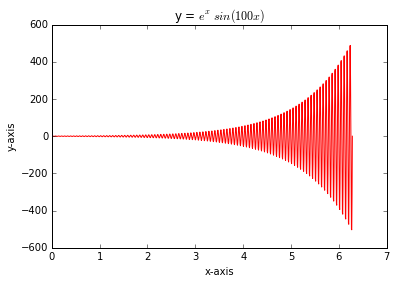

In [40]:
# This inputs a list of 100 numbers equally spaced from 0 to 10
x = np.linspace(0,2*math.pi,1000)

# Now we are using the functions from pylab to make a list for y and y1 based on the list for x
y = np.exp(x)*np.sin(100*x)


# This plots x vs y with yellow circle and then x vs y1 with green squares
plt.plot(x,y,"r-")

# Makes the graphs y-limits go from -1.1 to 1.1 



#Finally the code below adds x and y axis labels and then displays the graph
plt.title("y = $e^xsin(100x)$")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.show()

<div class=answer>
<div/>
This will be a difficult integral to take due to all the change of direction and noise at the end.

Then, see how Romberg fares on this integral.  Comment.

In [42]:
def messy_integral(x):
    return math.exp(x)*math.sin(100*x)

I = romberg.romberg(messy_integral,(0,2*math.pi),1e-10,verbose=True)

integrating on range (0, 6.283185307179586)

R(0,0) +6.609362413411554e-12

R(1,0) +3.447489430260185e-12 epsilon(1,0) -1.0540e-12
R(1,1) +2.393531769209728e-12



<div class=answer>
<div/>
It gives a very small value but I am unsure if it is the accuracy that we want.

Now try the integral
$$
\int_0^{2\pi} e^x \sin 128x \,dx.
$$
See how Romberg fares on this integral, and comment on why.
Please attach your plot of the integrand.

In [44]:
def messy_integral2(x):
    return math.exp(x)*math.sin(128*x)

I = romberg.romberg(messy_integral2,(0,2*math.pi),1e-10,verbose=True)

integrating on range (0, 6.283185307179586)

R(0,0) -5.274161174863635e-11

R(1,0) -2.751039172392076e-11 epsilon(1,0) +8.4104e-12
R(1,1) -1.909998504901557e-11



<div class=answer>
<div/>
It again gives a very small value which makes sense because there is more change of direction and messiness in this function causing there to be less area under the curve.

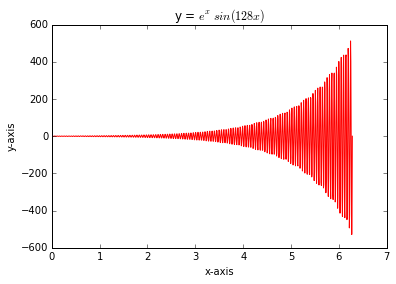

In [46]:
# This inputs a list of 1000 numbers equally spaced from 0 to 10
x = np.linspace(0,2*math.pi,1000)

# Now we are using the functions from pylab to make a list for y and y1 based on the list for x
y = np.exp(x)*np.sin(128*x)


# This plots x vs y with yellow circle and then x vs y1 with green squares
plt.plot(x,y,"r-")

# Makes the graphs y-limits go from -1.1 to 1.1 



#Finally the code below adds x and y axis labels and then displays the graph
plt.title("y = $e^xsin(128x)$")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.show()

## Exercise 6
### Integrals over infinite ranges

Let us start by reproducing Newmans's Example 5.3 (on page 180).  But please ignore Newman's code for Gaussian integration.  Instead, we will continue to use our own Romberg integration function.

Integrands which involve the Gaussian $e^{-x^2}$ show up throughout
physics.  The basic Gaussian integral has a simple known value, so we
will use it as our test case (as we used last week ):
$$
\int_{-\infty}^\infty e^{-x^2}\,dx=\sqrt{\pi}.
$$

The integrand is symmetric, so we are free to consider just one half
($\int_{0}^\infty e^{-x^2}\,dx$), as Newman uses for his example, then
double the result.  Let us transform this integral according
to (5.67), to make sure we see how Newman got his expression.

**Sorry about the
overloading of Gauss's name. A "Gaussian integral" is an integral of
the Gaussian function.  "Gaussian integration" is integration by Gaussian
quadrature.  The two are not particularly related.**

<div class=answer>
<div/>
Did this by hand.

Now try to evaluate the transformed integral using the Romberg
method.  What problem do you encounter, and how can you fix it?
It will help to make a plot of the integrand.

**Hint:** From looking at the plot,  what is the integrand's limit as $z\rightarrow 1$?


In [47]:
def fun(z):
    return math.exp(-z**2/(1-z)**2)/(1-z)**2

actual = math.sqrt(math.pi)/2

I = romberg.romberg(fun,(0,1),1e-10,verbose=True,reference = actual)


integrating on range (0, 1)
  reference value +8.86227e-01



ZeroDivisionError: division by zero

<div class=answer>
<div/>
There is a division by 0, we could fix it by doing a number that is a little less then 0

Finally, how does the Romberg method fare on the integral? Explain.

In [27]:
I = romberg.romberg(fun,(0,1-1e-10),1e-10,verbose=True,reference = actual)

integrating on range (0, 0.9999999999)
  reference value +8.86227e-01

R(0,0) +4.999999999500000e-01 ... residual +3.8623e-01

R(1,0) +9.857588823914606e-01 epsilon(1,0) +1.6192e-01 ... residual -9.9532e-02
R(1,1) +1.147678509871947e+00 ... residual -2.6145e-01

R(2,0) +8.910794433893940e-01 epsilon(2,0) -3.1560e-02 ... residual -4.8525e-03
R(2,1) +8.595196303887052e-01 epsilon(2,1) -1.9211e-02 ... residual +2.6707e-02
R(2,2) +8.403090384231556e-01 ... residual +4.5918e-02

R(3,0) +8.840312978302247e-01 epsilon(3,0) -2.3494e-03 ... residual +2.1956e-03
R(3,1) +8.816819159771683e-01 epsilon(3,1) +1.4775e-03 ... residual +4.5450e-03
R(3,2) +8.831594016830658e-01 epsilon(3,2) +6.8016e-04 ... residual +3.0675e-03
R(3,3) +8.838395661792549e-01 ... residual +2.3874e-03

R(4,0) +8.855767607479196e-01 epsilon(4,0) +5.1515e-04 ... residual +6.5016e-04
R(4,1) +8.860919150538178e-01 epsilon(4,1) +2.9400e-04 ... residual +1.3501e-04
R(4,2) +8.863859149922610e-01 epsilon(4,2) +5.1214e-05 ... residu

<div class=answer>
<div/>
When looking at it now it is within error of the actual value

Plot your transformed integrand.

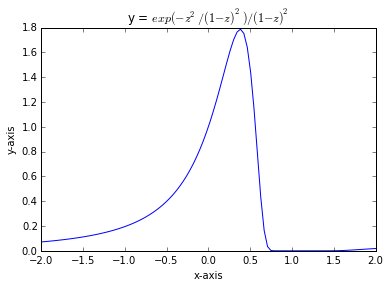

In [38]:
x = np.linspace(-2,2,100)
y = []

for l in range(len(x)):
    y.append(fun(x[l]))
    
plt.plot(x,y)
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.title("y = $exp(-z^2/(1-z)^2)/(1-z)^2$")


## Numerical differentiation

** Newman Exercise 5.15 **

Create a user-defined function ```f(x)``` that returns the value $1 + \frac{1}{2} \tanh(2x)$, then use a central difference to calculate the derivative of the function in the range $-2\le x\le2$.  Calculate an analytic formula for the derivative and make a graph with your numerical result and the analytic answer on the same plot.  It may help to plot the exact answer as lines and the numerical one as dots.  

**Hint:** In Python the ```tanh``` function is found in the ```math``` package, and it's called simply ```tanh```.

Please attach your code and plots.


In [59]:
def f_tanh(x):
    return 1 + math.tanh(2*x)/2

f = 1-1e-10
h = 1e-10
x0 = np.linspace(0,10,100)
deriv = []

for i in range(x0): 
    f_prime = (f_tanh(x0[i] + h/2) - f_tanh(x0[i] - h/2))/h
    deriv.append(f_prime)
    
f_prime_actual = np.sech(2*x)

plt.plot(x0,f_prime)
plt.plot(x0,f_prime_actual)
    

TypeError: only integer arrays with one element can be converted to an index